# Kézzel írott számjegyek felismerése konvolúciós hálóval

In [44]:
import numpy as np 
import math
import matplotlib.pyplot as plt
%matplotlib inline
import struct
import gc
import tensorflow as tf

In [45]:
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets("",one_hot=True)

#tanito bemenetek beolvasasa
f=open("mnist_database/train_60k_images.dat","rb")
signature,=struct.unpack(">I",f.read(4))
numimages,=struct.unpack(">I",f.read(4))
rows,=struct.unpack(">I",f.read(4))
cols,=struct.unpack(">I",f.read(4))
if (rows!=28) or (cols!=28) or (signature!=2051) or (numimages!=60000):
    print("Hiba!")
else:
    train_images=np.empty([60000,784],dtype="float32")
    for i in range(60000):
        train_images[i]=np.array(struct.unpack("784B",f.read(784)),dtype="float32")/255
f.close()

#tanito kimenetek beolvasasa
f=open("mnist_database/train_60k_labels.dat","rb")
fdata=f.read()
f.close()
signature,=struct.unpack(">I",fdata[0:4])
numlabels,=struct.unpack(">I",fdata[4:8])
if (signature!=2049) or (numlabels!=60000):
    print("Hiba!")
else:
    train_labels=np.zeros([60000,10])
    for i in range(60000):
        temp,=struct.unpack("B",fdata[8+i])
        train_labels[i][temp]=1
fdata=[]

#teszt bemenetek beolvasasa
f=open("mnist_database/test_10k_images.dat","rb")
signature,=struct.unpack(">I",f.read(4))
numimages,=struct.unpack(">I",f.read(4))
rows,=struct.unpack(">I",f.read(4))
cols,=struct.unpack(">I",f.read(4))
if (rows!=28) or (cols!=28) or (signature!=2051) or (numimages!=10000):
    print("Hiba!")
else:
    test_images=np.empty([10000,784],dtype="float32")
    for i in range(10000):
        test_images[i]=np.array(struct.unpack("784B",f.read(784)),dtype="float32")/255
f.close()

#teszt kimenetek beolvasasa
f=open("mnist_database/test_10k_labels.dat","rb")
fdata=f.read()
f.close()
signature,=struct.unpack(">I",fdata[0:4])
numlabels,=struct.unpack(">I",fdata[4:8])
if (signature!=2049) or (numlabels!=10000):
    print("Hiba!")
else:
    test_labels=np.zeros([10000,10])
    for i in range(10000):
        temp,=struct.unpack("B",fdata[8+i])
        test_labels[i][temp]=1
fdata=[]

gc.collect()
print("MNIST adatbazis betoltve.")

Extracting train-images-idx3-ubyte.gz
Extracting train-labels-idx1-ubyte.gz
Extracting t10k-images-idx3-ubyte.gz
Extracting t10k-labels-idx1-ubyte.gz
MNIST adatbazis betoltve.


In [46]:
sess = tf.Session()
# bemenet és kimenet definiálása
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])
# a súlymátrixa és bias vektor definiálása
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))
# inicializálás
sess.run(tf.initialize_all_variables())
# a regresszió létrehozása
y = tf.nn.softmax(tf.matmul(x,W) + b)
# a költségfüggvény megadása
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
# optimációs algoritmus megadása 
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
# tanítás 1000 epoch, 50-es batch méret
for i in range(300):
  batch = mnist.train.next_batch(50)
  train_step.run(session=sess, feed_dict={x: batch[0], y_: batch[1]})

In [47]:
# ez megadja, hogy hányszor találtuk el
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
# ez pedig kitszámolja ezek átlagát
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# most pedig lefuttatjuk a teszt képekre
print(accuracy.eval(session=sess, feed_dict={x: test_images, y_: test_labels}))

0.888


In [50]:
# változók inicializálása. Mivel ReLU-t fogunk használni, ezért fontos, hogy pozitív érétkük legyen.

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1, name="weights")
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

# konvolúciós és max-pool rétegek inicializálása

def conv2d(x, W, name):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME', name=name)

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# háló architektúrájának összerakása

# első konvolúciós réteg 1@28x28,f:5x5@32,z:2x2
x_image = tf.reshape(x, [-1,28,28,1])

W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, "h_conv1") + b_conv1) # 28x28 ---> 28x28
h_pool1 = max_pool_2x2(h_conv1) # 28x28 ---> 14x14

# második konvolúciós réteg 32@28x28,f:5x5@64,z:2x2
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2, "h_conv2") + b_conv2) # 14x14 ---> 14x14
h_pool2 = max_pool_2x2(h_conv2) # 14x14 ---> 7x7

# fully connected rétegek
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# dropout a kimeneti réteg előtt
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
                   
# kimeneti softmax réteg
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv=tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

In [51]:
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y_conv), reduction_indices=[1]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.initialize_all_variables())
for i in range(50):#1000
  batch = mnist.train.next_batch(50)
  if i%100 == 0:
    train_accuracy = accuracy.eval(session=sess, feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(session=sess, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

#print("test accuracy %g" % accuracy.eval(session=sess, feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.06


In [52]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, confusion_matrix
# először is nyerjük ki a predikciókat (valószínüség és hozzá tartozó pontosságot)
#test_accuracy, y_pred = sess.run([accuracy, y_conv], feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0})
#y_pred = sess.run(y_conv, feed_dict={x: mnist.test.images[0:5], y_: mnist.test.labels[0:5], keep_prob: 1.0})
y_pred=np.empty(test_images.shape[0])
for i in range(test_images.shape[0]): # egyszerre is ra lehetne adni, de ahhoz sok memoria kell
    temp = sess.run(y_conv, feed_dict={x: np.atleast_2d(test_images[i]), y_: np.atleast_2d(test_labels[i]), keep_prob: 1.0})
    y_pred[i]=np.argmax(temp,1)

#print("test accuracy: %g" %(test_accuracy))
#y_true = np.argmax(mnist.test.labels,1)
#print("Precision", precision_score(y_true, y_pred, average="macro"))
#print("Recall", recall_score(y_true, y_pred, average="macro"))
#print("f1_score", f1_score(y_true, y_pred, average="macro"))
#print("\nKonfúziós mátrix: ")
#print(confusion_matrix(y_true, y_pred))

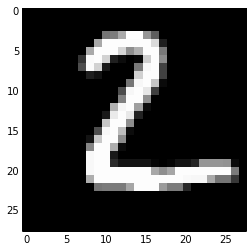

In [53]:
testInputToShow = test_images[1]
plt.imshow(np.reshape(testInputToShow,[28,28]), interpolation="nearest", cmap="gray");

In [54]:
def showConvActivationAtFilterx(layer,inputdata):
    # ez jelent egy forward propagation-t az adott rétegig, amit paraméterben adunk át
    units = layer.eval(session=sess,feed_dict={x:np.reshape(inputdata,[1,784],order='F'),keep_prob:1.0})
    # az adott réteghez tartozó tömbnek a negyedik (3-as indexű) dimenzija tartalmazza az adott konvolúciós "szeletek" kimenetét
    filters = units.shape[3]
    # létrehozunk egy új ábrát
    plt.figure(1, figsize=(32,32))
    # majd az egyes kimeneteket külön ábrázoljuk
    for i in range(0,filters):
        plt.subplot(math.ceil(filters/6),6,i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="none", cmap="gray")

IndexError: index out of range

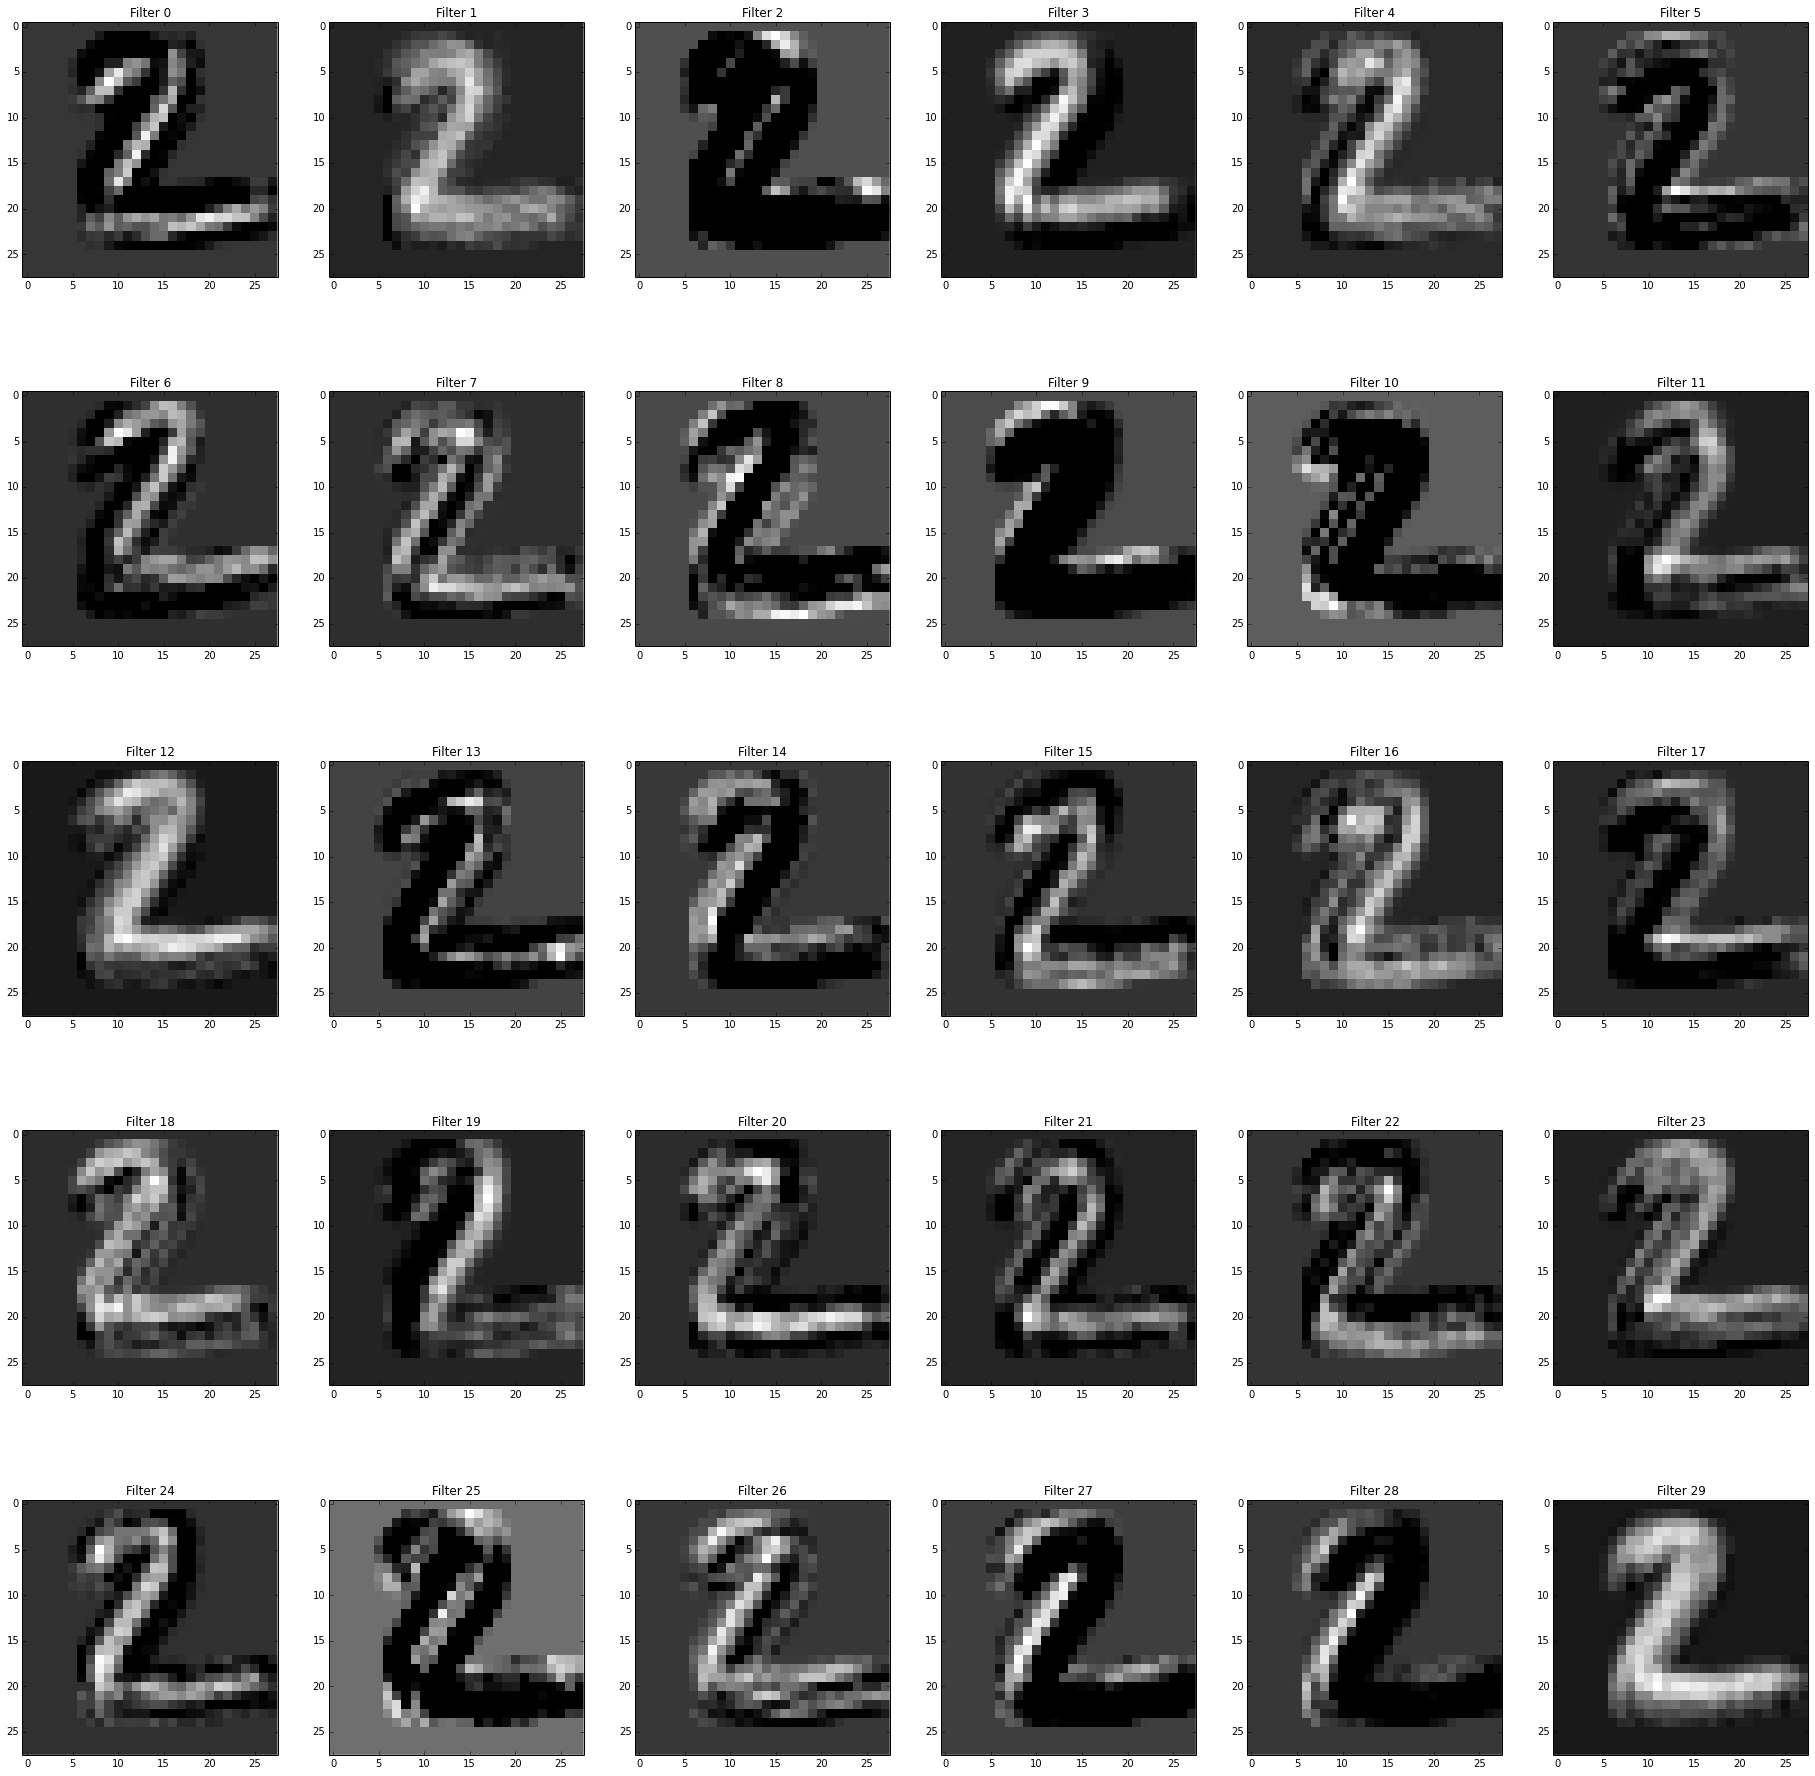

In [55]:
showConvActivationAtFilterx(h_conv1, testInputToShow) # az első konvolúciós réteg kimeneteinek megjelenítése

IndexError: index out of range

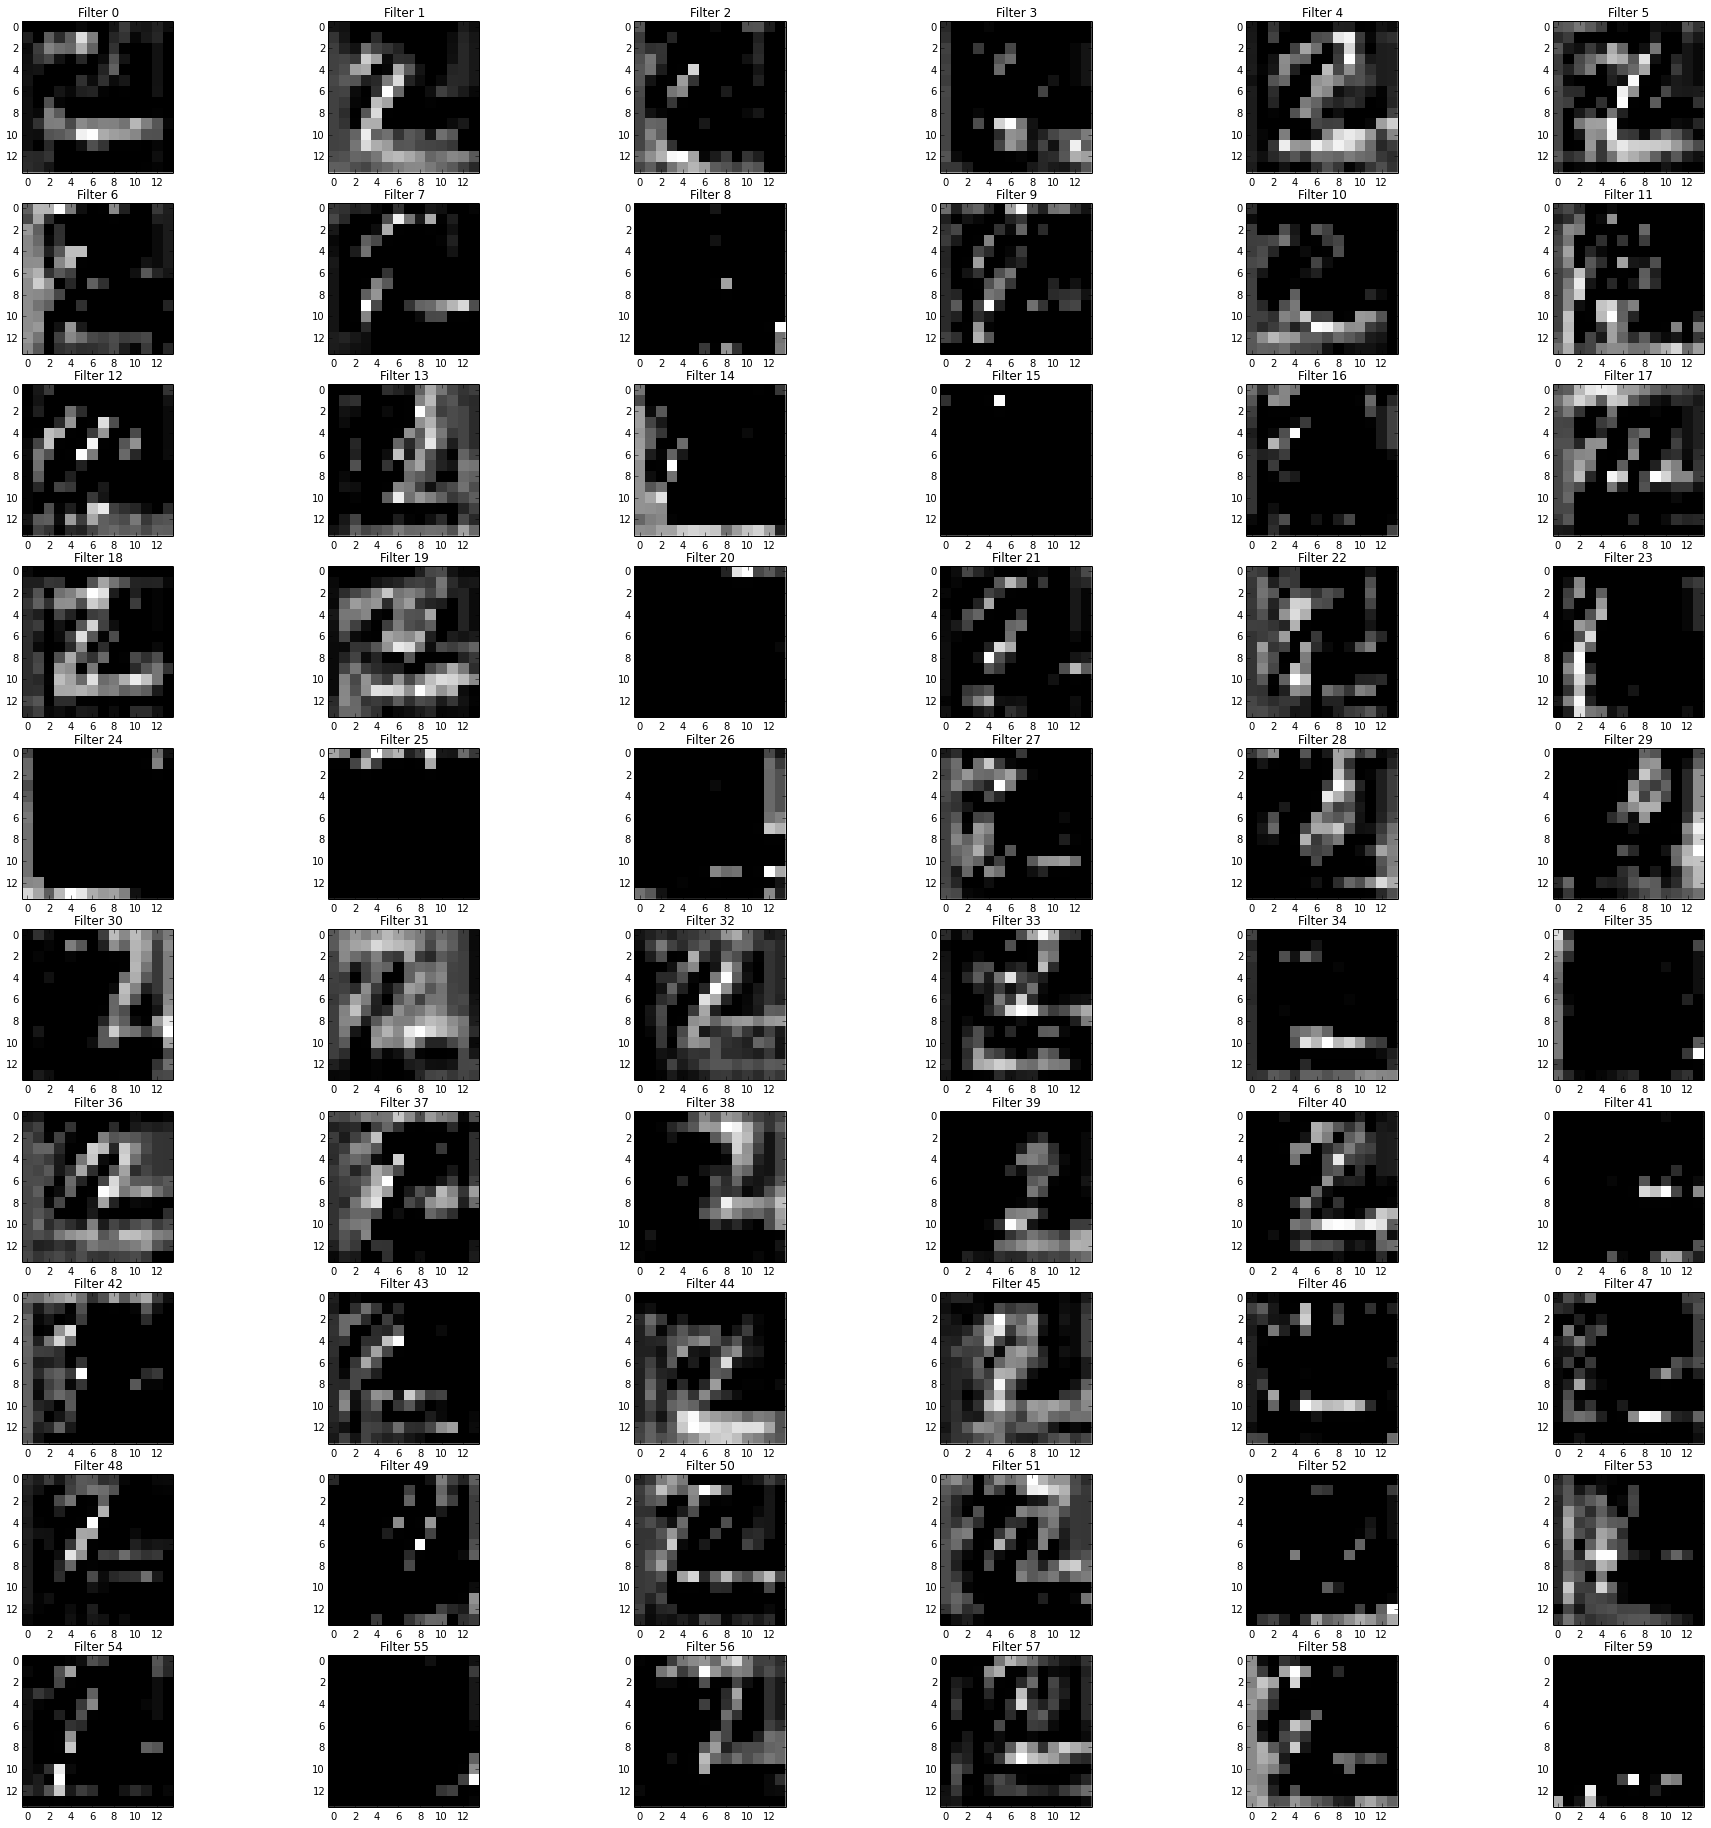

In [56]:
showConvActivationAtFilterx(h_conv2, testInputToShow) # a második konvolúciós réteg kimeneteinek megjelenítése

In [57]:
def showConvFilterx(w):
    # az adott réteghez tartozó súlyok lekérdezése
    weights=w.eval(session=sess)
    # a szűrők száma a súlymátrix negyedik (3-as indexű) dimenziója
    no_filters=weights.shape[3]
    plt.figure(1, figsize=(32,32))
    for i in range(0,no_filters):
        plt.subplot(math.ceil(no_filters/6),6,i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(weights[:,:,0,i], interpolation="none", cmap="gray") 

IndexError: index out of range

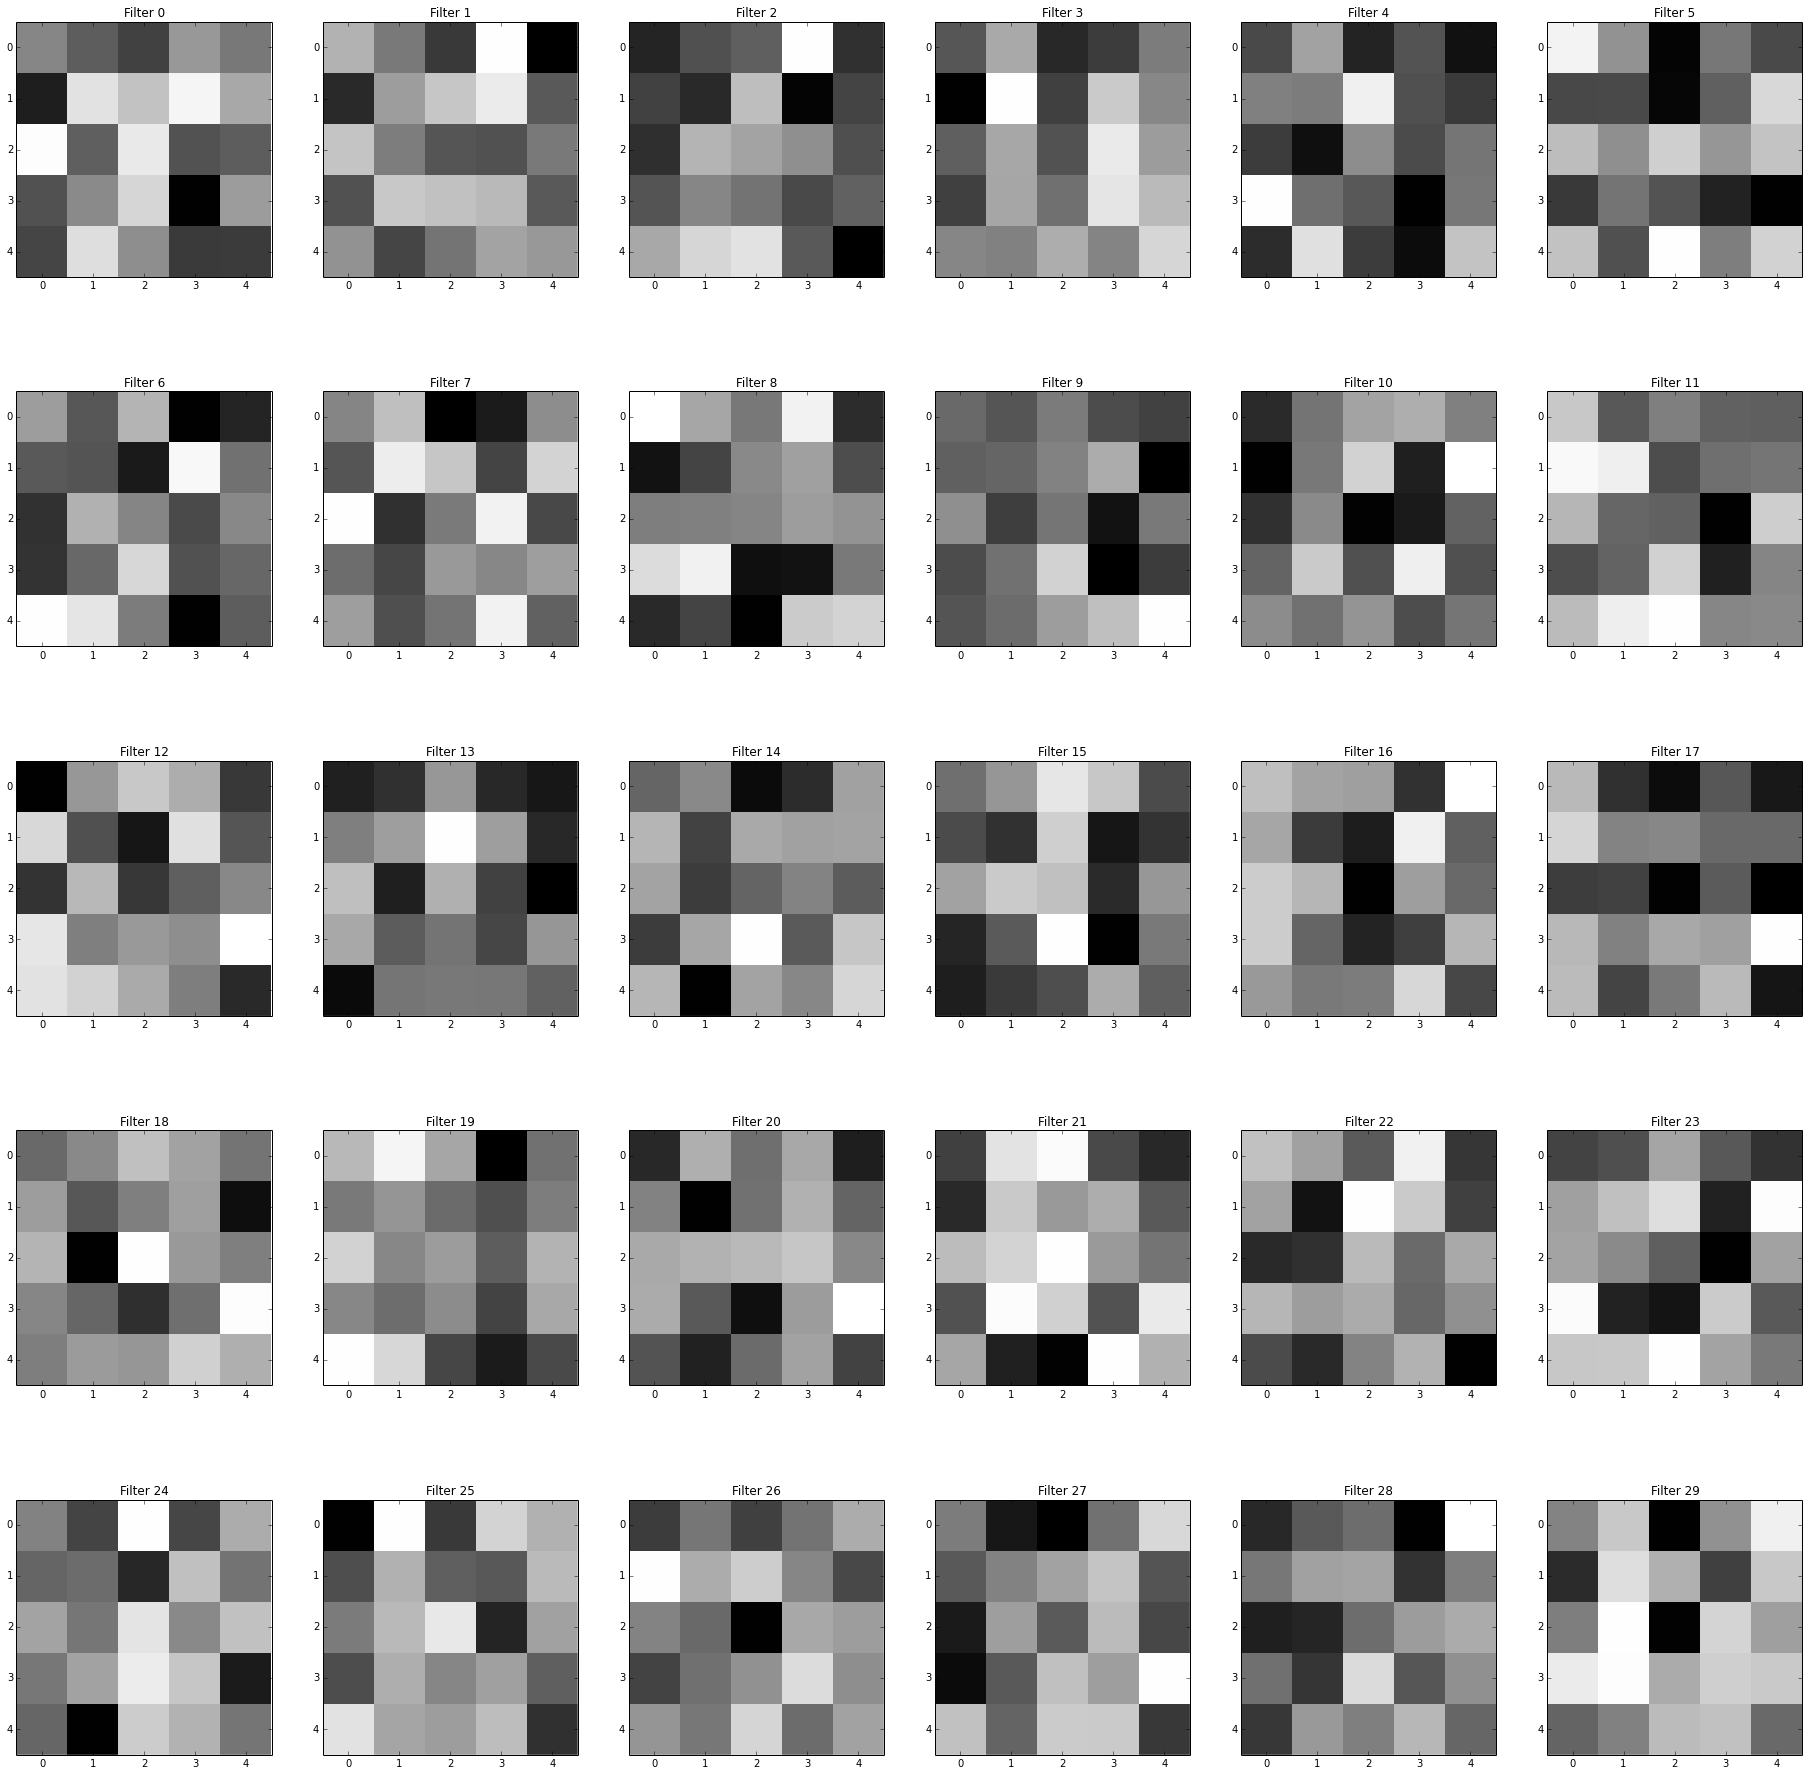

In [58]:
showConvFilterx(W_conv1) # első konvolúció réteghez tartozó szűrők súlyainak megjelenítése

IndexError: index out of range

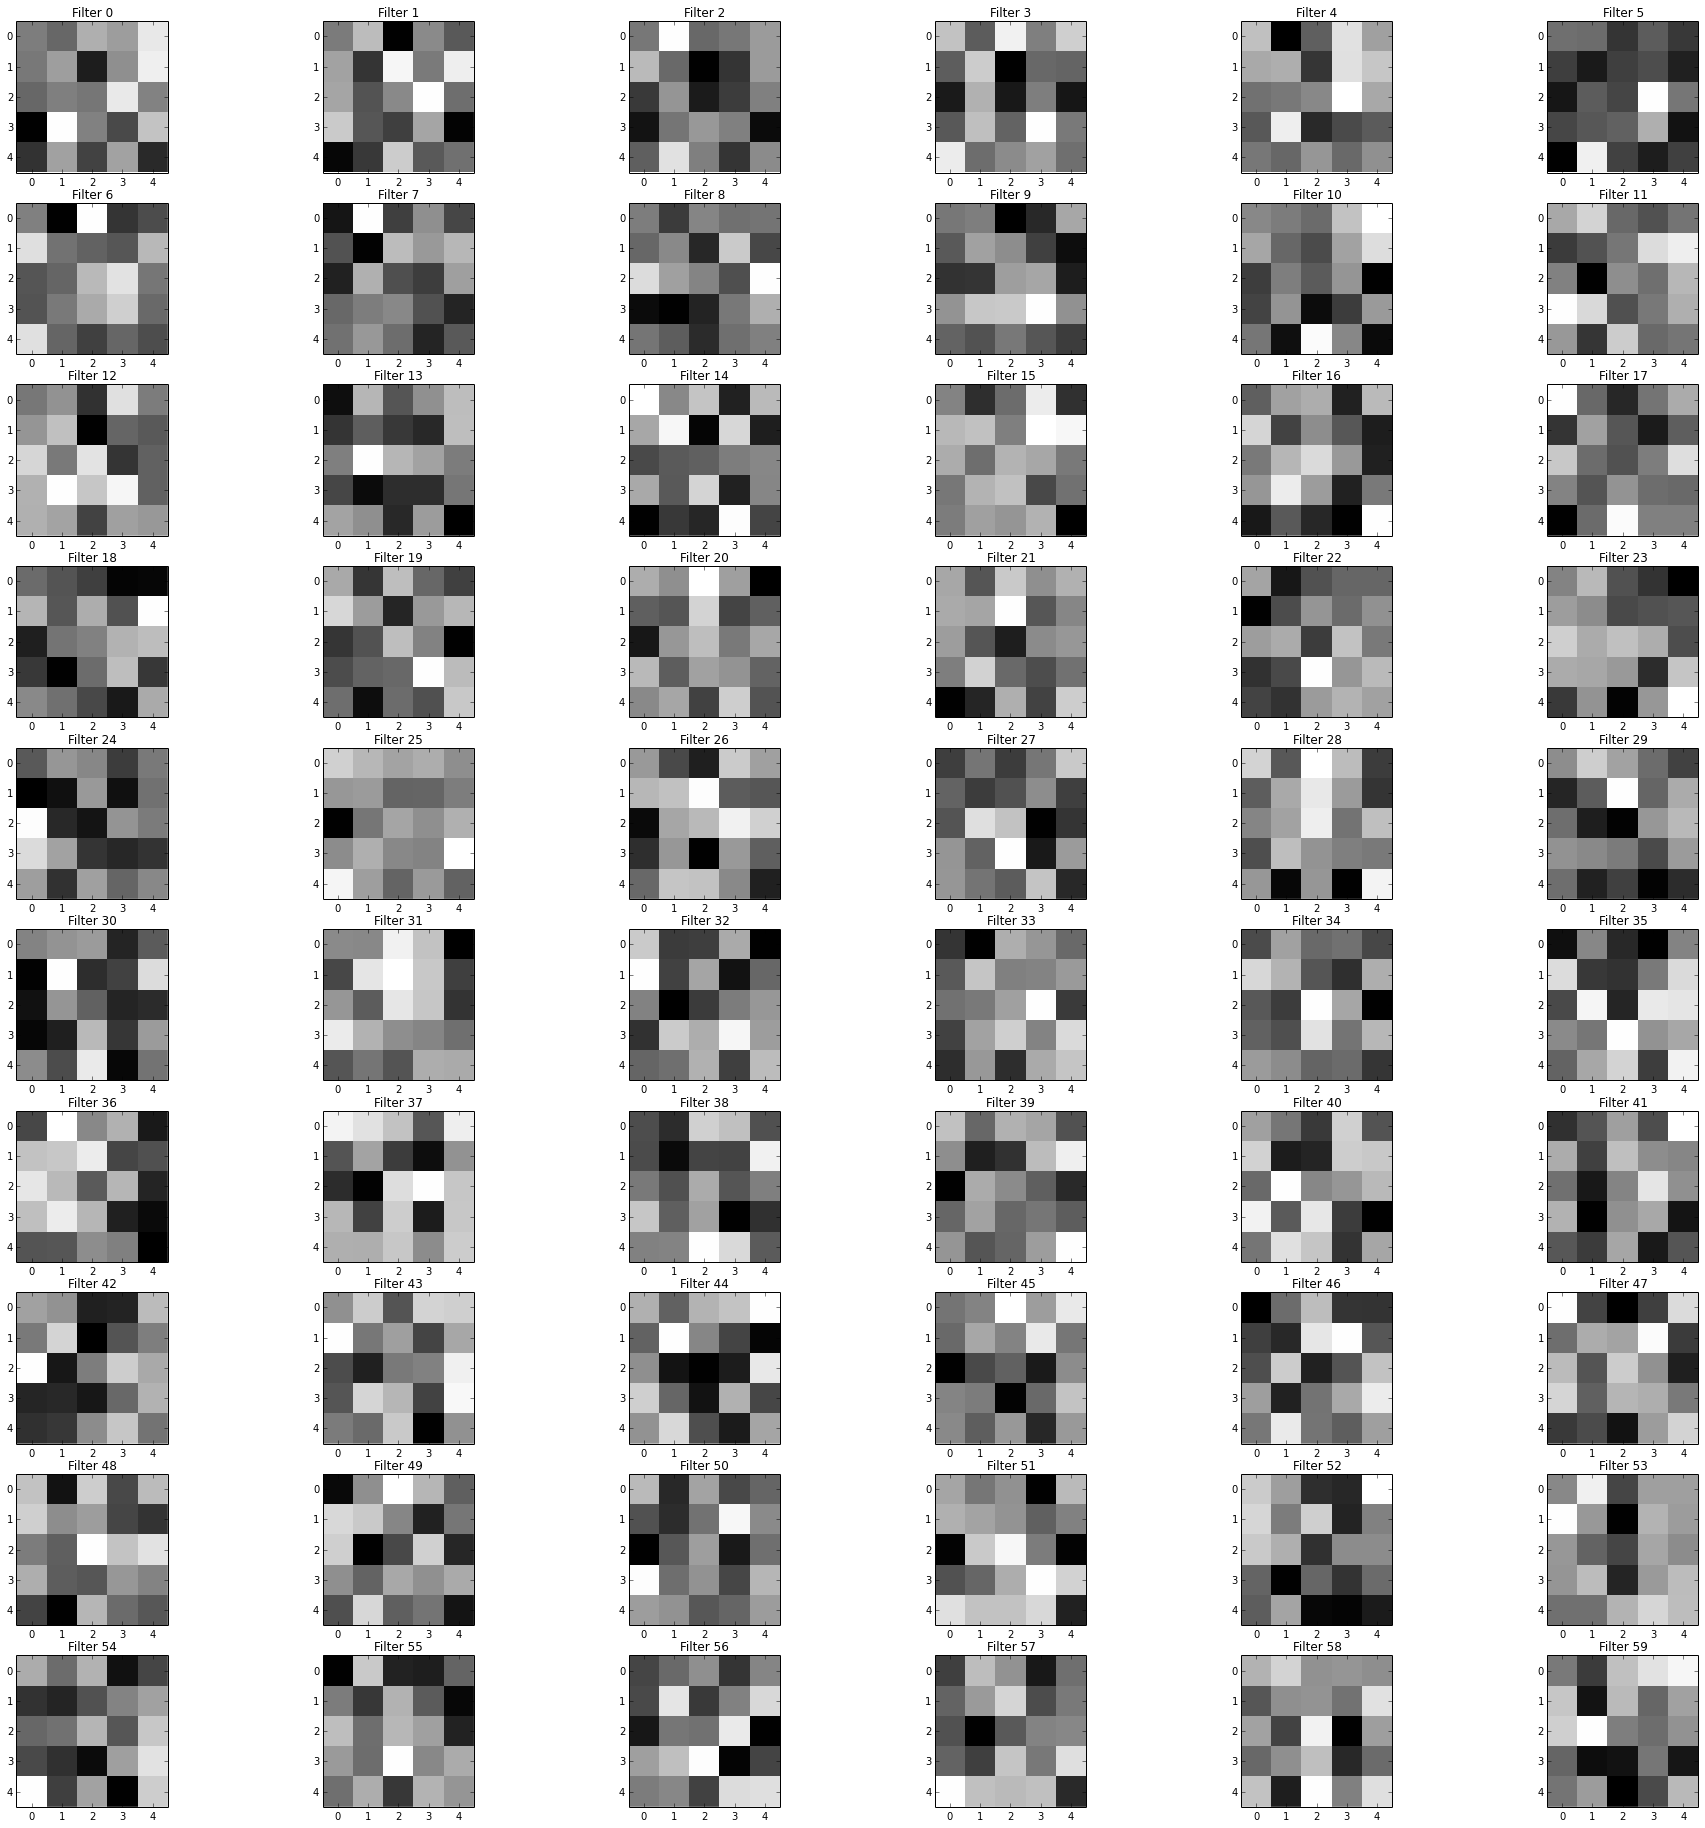

In [59]:
showConvFilterx(W_conv2) # második konvolúció réteghez tartozó szűrők súlyainak megjelenítése